# Building a Euribor Curve - Interpolation Analysis - Simple Case

We build an Ibor single-curve and examine different interpolation choices for a simple curve.

This follows:

https://quant.stackexchange.com/questions/53904/monotonic-cubic-spline-interpolation-quantlib-python?rq=1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.rates import *

####################################################################
# FINANCEPY BETA Version 0.200 - This build:  14 Jul 2021 at 16:00 #
# **** NEW PEP8 COMPLIANT VERSION -- PLEASE UPDATE YOUR CODE  **** #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



In [3]:
valuation_date = Date(12, 5, 2020)

## Building the Single Curve

Build the Ibor Curve

In [4]:
cal = CalendarTypes.TARGET

depoDCCType = DayCountTypes.ACT_360
depos = []
spot_days = 0
settlement_date = valuation_date.add_weekdays(spot_days)
depo = IborDeposit(settlement_date, "6M", -0.114/100.0, depoDCCType, calendar_type=cal); depos.append(depo)
fraDCCType = DayCountTypes.ACT_360

fras = []
fra = IborFRA(settlement_date.add_tenor("6M"), "6M", -0.252/100.0, fraDCCType, calendar_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("12M"), "6M", -0.306/100.0, fraDCCType, calendar_type=cal); fras.append(fra)

swaps = []
swapType = SwapTypes.PAY
fixedDCCType = DayCountTypes.THIRTY_E_360_ISDA
fixedFreqType = FrequencyTypes.ANNUAL

swap = IborSwap(settlement_date, "2Y", swapType, -0.325/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "3Y", swapType, -0.347/100.0, fixedFreqType, fixedDCCType, calendar_type=cal); swaps.append(swap)

iborDepos = depos.copy()
iborFras = fras.copy()
ibor_swaps = swaps.copy()

In [5]:
iborCurves = {}
for interp_type in InterpTypes:
    iborCurve = IborSingleCurve(valuation_date, iborDepos, iborFras, ibor_swaps, interp_type)
    iborCurves[interp_type] = iborCurve

Set up a list of dates

In [6]:
gridDates = []
dt = Date(12, 5, 2020); gridDates.append(dt)
dt = dt.add_tenor("6M"); gridDates.append(dt)
dt = dt.add_tenor("6M"); gridDates.append(dt)
dt = dt.add_tenor("6M"); gridDates.append(dt)
dt = dt.add_tenor("6M"); gridDates.append(dt)
dt = dt.add_tenor("12M"); gridDates.append(dt)

In [7]:
print("              ", end="")

for interp in InterpTypes:
    print("%13s "% interp.name[0:15], end="")
print("")
    
for dt in gridDates:
    print("%12s"% dt.str("X"), end="")
    for interp in InterpTypes:
        iborCurve = iborCurves[interp]
        df = iborCurve.df(dt) / iborCurve.df(settlement_date)
        print("%15.7f "% (df), end="")
    print("")

              FLAT_FWD_RATES LINEAR_FWD_RATE LINEAR_ZERO_RAT FINCUBIC_ZERO_R NATCUBIC_LOG_DI NATCUBIC_ZERO_R PCHIP_ZERO_RATE PCHIP_LOG_DISCO 
   12MAY2020      1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000 
   12NOV2020      1.0005830       1.0005830       1.0005830       1.0005830       1.0005830       1.0005830       1.0005830       1.0005830 
   12MAY2021      1.0018524       1.0018524       1.0018524       1.0018524       1.0018524       1.0018524       1.0018524       1.0018524 
   12NOV2021      1.0034217       1.0034217       1.0034217       1.0034217       1.0034217       1.0034217       1.0034217       1.0034217 
   12MAY2022      1.0065272       1.0065272       1.0065272       1.0065272       1.0065272       1.0065272       1.0065272       1.0065272 
   12MAY2023      1.0104754       1.0104754       1.0104754       1.0104754       1.0104754       1.0104754       1.0104754       1.0104754 


This agrees perfectly with QL.

Now shift the dates and you see the different impact of the different interpolation schemes.

In [8]:
shiftedDates = []
for dt in gridDates:
    shiftedDates.append(dt.add_tenor("15D"))

In [18]:
print("              ", end="")

for interp in InterpTypes:
    print("%8s "% interp.name[0:13], end="")
print("")
    
for dt in shiftedDates:
    print("%8s "% dt.str("X"), end="")
    for interp in InterpTypes:
        iborCurve = iborCurves[interp]
        df = iborCurve.df(dt) / iborCurve.df(settlement_date)
        print("%12.6f "% (df), end="")
    print("")

              FLAT_FWD_RATE LINEAR_FWD_RA LINEAR_ZERO_R FINCUBIC_ZERO NATCUBIC_LOG_ NATCUBIC_ZERO PCHIP_ZERO_RA PCHIP_LOG_DIS 
27MAY2020     1.000048     1.000048     1.000048     1.000047     1.000031     1.000047     1.000048     1.000022 
27NOV2020     1.000688     1.000635     1.000662     1.000653     1.000668     1.000653     1.000636     1.000654 
27MAY2021     1.001980     1.001959     1.001964     1.001972     1.001955     1.001972     1.001971     1.001967 
27NOV2021     1.003679     1.003560     1.003642     1.003614     1.003631     1.003612     1.003606     1.003611 
27MAY2022     1.006689     1.006781     1.006680     1.006789     1.006774     1.006799     1.006698     1.006731 
27MAY2023     1.010638     1.010638     1.010620     1.010625     1.010593     1.010554     1.010619     1.010570 


This shows that the interpolations do not match once we are off the grid times.

## Curve Shape Analysis

Look at short end

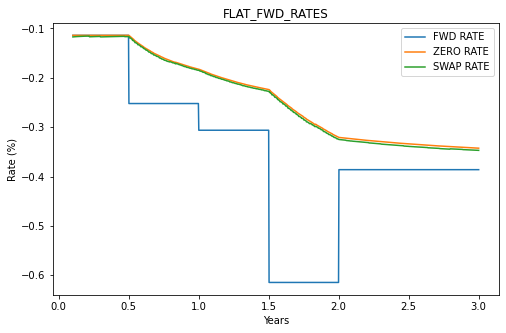

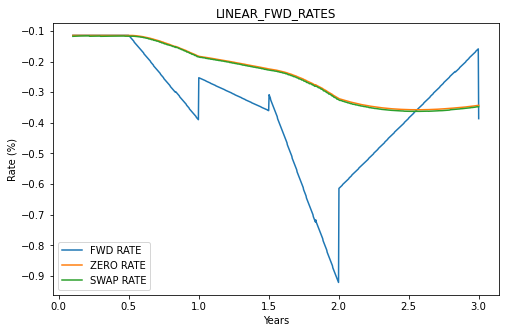

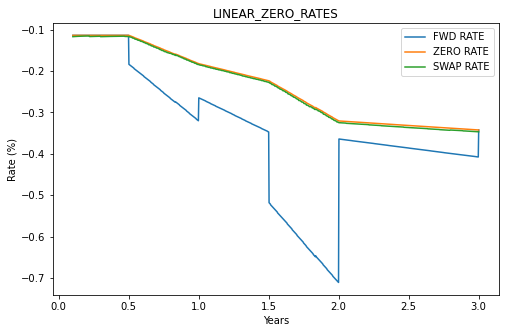

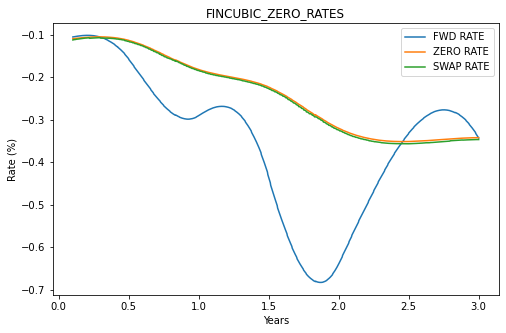

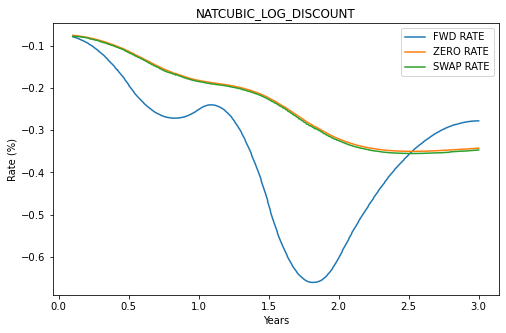

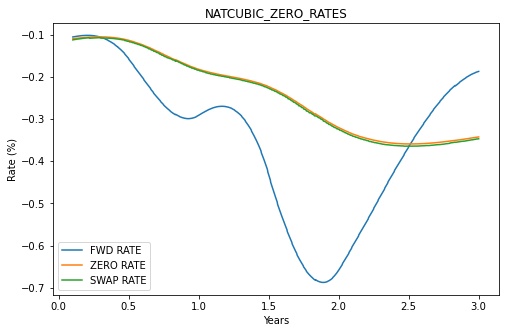

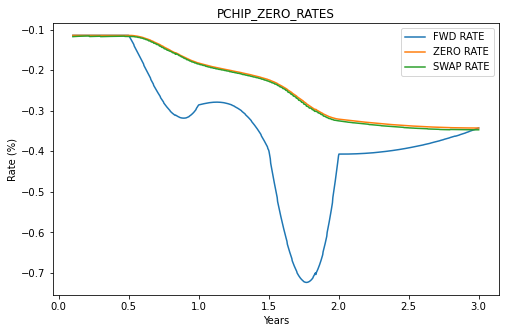

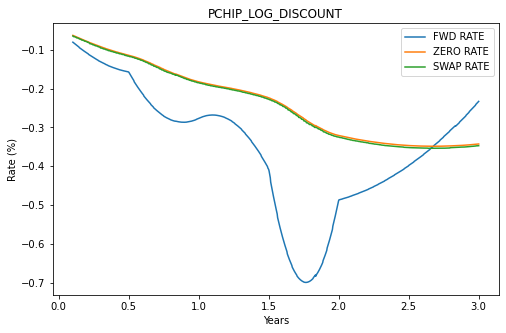

In [20]:
years = np.linspace(0.1, 3, 1000)
plotDates = settlement_date.add_years(years)

for interp_type in InterpTypes:

    plt.figure(figsize=(8,5))
    iborCurve = iborCurves[interp_type]
    iborCurveFwdRate = iborCurve.fwd_rate(plotDates, "1D")
    iborCurveZeroRate = iborCurve.zero_rate(plotDates)
    iborCurveSwapRate = iborCurve.swap_rate(settlement_date, plotDates)
    
    plt.plot(years, iborCurveFwdRate*100.0, label="FWD RATE")
    plt.plot(years, iborCurveZeroRate*100.0, label="ZERO RATE")
    plt.plot(years, iborCurveSwapRate*100.0, label="SWAP RATE")

    plt.title(interp_type.name)
    plt.xlabel("Years")
    plt.ylabel("Rate (%)")
    plt.legend();

Copyright (c) Dominic O'Kane 2020